In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from pprint import pprint

import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from matplotlib import ticker

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [3]:
logistic_curve.parameters

('m', 'r', 's')

In [4]:
season_ranges = [
    SeasonRange(
        season="2022/2023", start_date=date(2022, 9, 5), end_date=date(2023, 4, 30)
    ),
    SeasonRange(
        season="2023/2024", start_date=date(2023, 9, 4), end_date=date(2024, 4, 28)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=6)

In [5]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 0.5, "sigma": 0.1},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=0.15,
            mu=0.0,
            sigma=0.015,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[0.1, 0.2],
            mu=[0.0, 0.0],
            sigma=[0.015, 0.015],
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.25, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 45.0, "sigma": 2.0},
        ),
    ],
    covariate_categories=[
        CovariateCategories(covariate="sex", categories=("female", "male")),
        CovariateCategories(covariate="age", categories=("youth", "adult", "senior")),
    ],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.0005,
    name="Test Model",
)
model

In [6]:
model.coordinates().get("season_by_category")

['season_2022_2023_sex_female_age_youth',
 'season_2022_2023_sex_female_age_adult',
 'season_2022_2023_sex_female_age_senior',
 'season_2022_2023_sex_male_age_youth',
 'season_2022_2023_sex_male_age_adult',
 'season_2022_2023_sex_male_age_senior',
 'season_2023_2024_sex_female_age_youth',
 'season_2023_2024_sex_female_age_adult',
 'season_2023_2024_sex_female_age_senior',
 'season_2023_2024_sex_male_age_youth',
 'season_2023_2024_sex_male_age_adult',
 'season_2023_2024_sex_male_age_senior']

In [7]:
pprint(model.coordinates())

{'covariate_age_categories': ['youth', 'adult', 'senior'],
 'covariate_age_categories_limited': ['adult', 'senior'],
 'covariate_names': ['sex', 'age'],
 'covariate_sex_categories': ['female', 'male'],
 'covariate_sex_categories_limited': ['male'],
 'parameters': ['m', 'r', 's'],
 'season': ['2022/2023', '2023/2024'],
 'season_2022_2023_dates': ['2022-09-05',
                            '2022-09-06',
                            '2022-09-07',
                            '2022-09-08',
                            '2022-09-09',
                            '2022-09-10',
                            '2022-09-11',
                            '2022-09-12',
                            '2022-09-13',
                            '2022-09-14',
                            '2022-09-15',
                            '2022-09-16',
                            '2022-09-17',
                            '2022-09-18',
                            '2022-09-19',
                            '2022-09-20',
        

In [8]:
model.build(debug=True)

INFO: Using 68 date ranges for the uptake model.
ERROR: No observations were provided, will not be able to calibrate model only sample from prior.
INFO: Added season 2022/2023 to the model with 238 days.
INFO: Added season 2023/2024 to the model with 238 days.
INFO: Added covariate MSeason to the model.
INFO: Added covariate MSex to the model.
INFO: Added covariate MAge to the model.
INFO: Added covariate RSeason to the model.
INFO: Added covariate SSeason to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20222023SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter RSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter SSeason20232024SexFemaleAgeYouth to the model.
INFO: Added summed parameter MSeason20222023SexFemaleAgeAdult to the 

In [9]:
model._model

                            MSeason ~ Normal(0.5, 0.1)
                               MSex ~ RandomWalk(Normal(0.15, 0.015), Normal(0, 0.015), f())
                     MAgePackedChol ~ _lkjcholeskycov(2, 1, Exponential(f()))
                               MAge ~ RandomWalk(MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), MultivariateNormal(f(MAgePackedChol), f(MAgePackedChol)), f(<multivariate_normal>))
                            RSeason ~ Normal(-3.25, 0.25)
                            SSeason ~ Normal(45, 2)
                            epsilon ~ Exponential(f())
 Incidence20222023SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex, MSeason, SSeason, RSeason))
 Incidence20232024SexFemaleAgeYouth ~ Gamma(f(epsilon, MSex, MSeason, SSeason, RSeason), f(epsilon, MSex, MSeason, SSeason, RSeason))
 Incidence20222023SexFemaleAgeAdult ~ Gamma(f(epsilon, MAge, MSex, SSeason, RSeason, MSeason), f(epsilon, MAge, MSex, SSeason, RSeason, MSeason))
 Inc

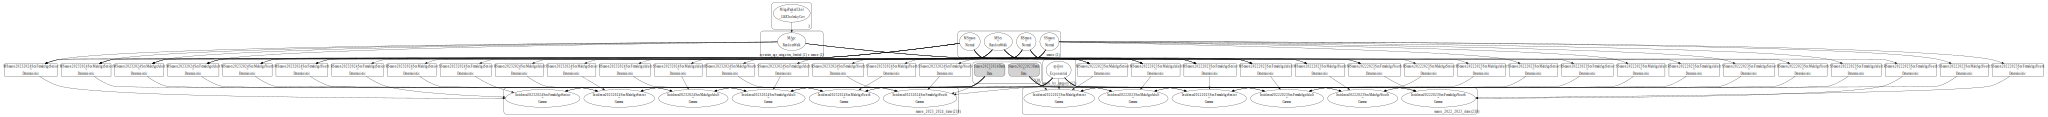

In [10]:
pm.model_to_graphviz(model._model)

In [11]:
prior = model.sample_prior()
prior

Sampling: [Incidence20222023SexFemaleAgeAdult, Incidence20222023SexFemaleAgeSenior, Incidence20222023SexFemaleAgeYouth, Incidence20222023SexMaleAgeAdult, Incidence20222023SexMaleAgeSenior, Incidence20222023SexMaleAgeYouth, Incidence20232024SexFemaleAgeAdult, Incidence20232024SexFemaleAgeSenior, Incidence20232024SexFemaleAgeYouth, Incidence20232024SexMaleAgeAdult, Incidence20232024SexMaleAgeSenior, Incidence20232024SexMaleAgeYouth, MAge, MAgePackedChol, MSeason, MSex, RSeason, SSeason, epsilon]


Inference data with groups:
	> prior
	> constant_data

In [12]:
adult_male_df = (
    prior.prior["Incidence20222023SexMaleAgeAdult"]
    .squeeze()
    .to_dataframe()
    .drop(columns="chain")
)
adult_male_df

Incidence20222023SexMaleAgeAdult
draw season_2022_2023_dates                                  
0    2022-09-05                                  2.172167e-03
     2022-09-06                                  2.102371e-03
     2022-09-07                                  2.373049e-03
     2022-09-08                                  2.317496e-03
     2022-09-09                                  2.665398e-03
...                                                       ...
499  2023-04-26                                  0.000000e+00
     2023-04-27                                  0.000000e+00
     2023-04-28                                  0.000000e+00
     2023-04-29                                  0.000000e+00
     2023-04-30                                 1.884443e-105

[119000 rows x 1 columns]

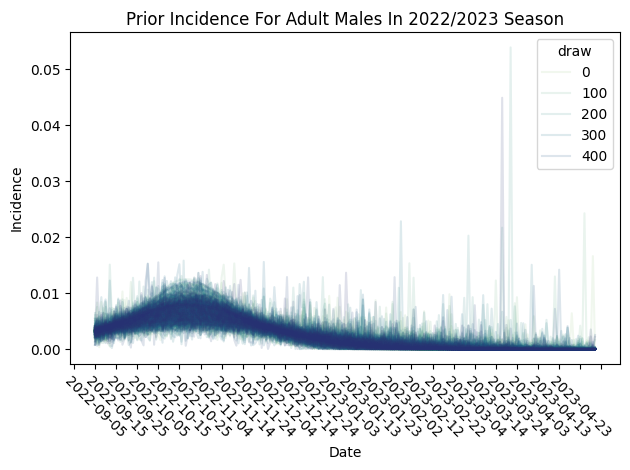

In [13]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Incidence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Incidence")
plt.title("Prior Incidence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()

In [14]:
adult_male_df = adult_male_df.reset_index().sort_values(
    by=["season_2022_2023_dates", "draw"]
)
adult_male_df["Prevalence20222023SexMaleAgeAdult"] = adult_male_df.groupby("draw")[
    "Incidence20222023SexMaleAgeAdult"
].cumsum()

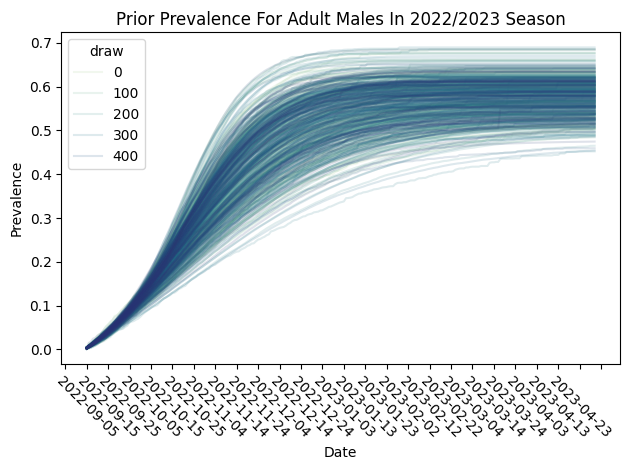

In [15]:
sns.lineplot(
    data=adult_male_df,
    x="season_2022_2023_dates",
    y="Prevalence20222023SexMaleAgeAdult",
    hue="draw",
    palette="crest",
    alpha=0.15,
)
plt.xlabel("Date")
plt.ylabel("Prevalence")
plt.title("Prior Prevalence For Adult Males In 2022/2023 Season")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.xticks(rotation=-45)
plt.tight_layout()
plt.show()